In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from scipy.stats import rankdata
from sklearn.decomposition import PCA
from tensorflow.keras import layers, models, regularizers, callbacks
from lightgbm import LGBMClassifier
import lightgbm as lgb

   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6   
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  \
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195   
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978  \
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0

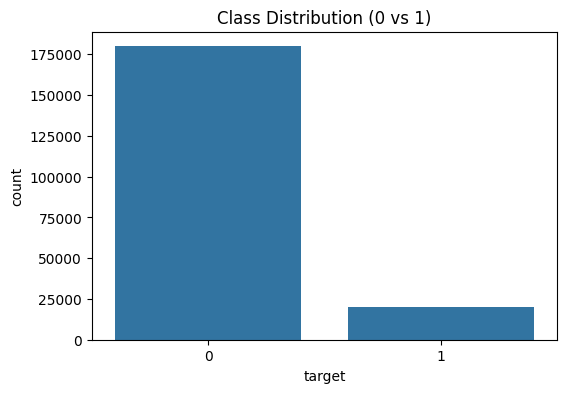

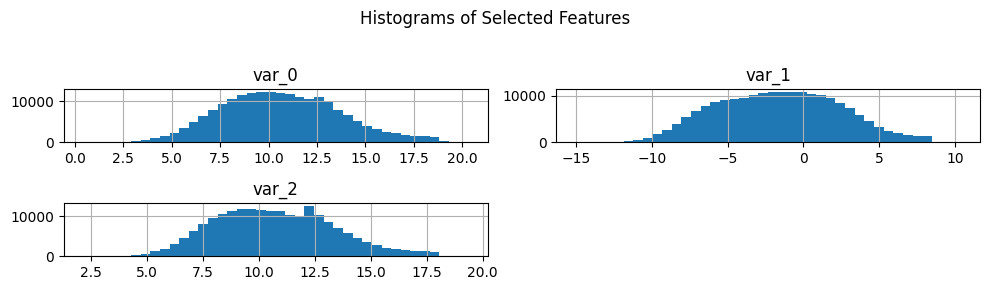

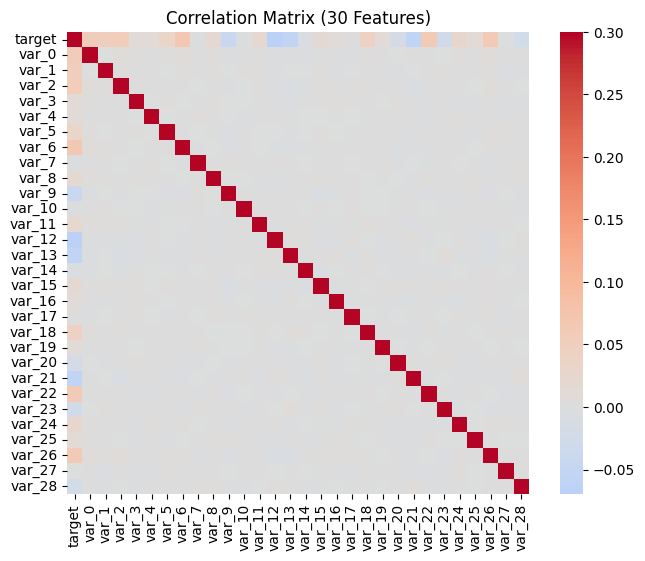

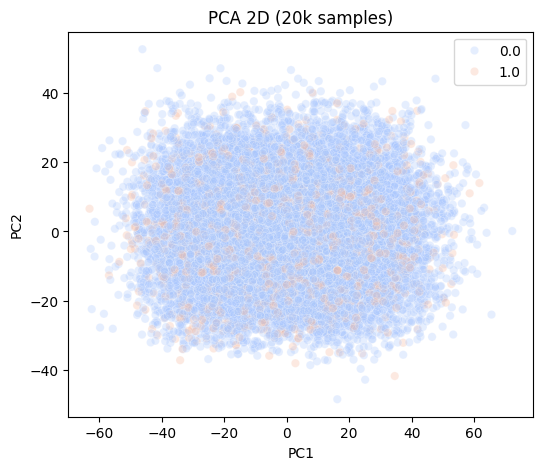

Train shape: (200000, 200), Test shape: (200000, 200), Positive ratio: 0.1005

── Fold 1 ──
391/391 [==============================] - 1s 2ms/step
MLP AUC: 0.84414
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

DATA_PATH = Path('.')
train_df = pd.read_csv(DATA_PATH / 'train.csv')
test_df  = pd.read_csv(DATA_PATH / 'test.csv')
sub_df   = pd.read_csv(DATA_PATH / 'sample_submission.csv')

print(train_df.head())
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution (0 vs 1)')
plt.show()

cols_to_plot = ['var_0','var_1','var_2']
train_df[cols_to_plot].hist(bins=40, figsize=(10, 3))
plt.suptitle('Histograms of Selected Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

sample_corr = train_df.iloc[:, 1:31].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(sample_corr, cmap='coolwarm', vmax=0.3, center=0, square=True)
plt.title('Correlation Matrix (30 Features)')
plt.show()

X_raw_sample = train_df.drop(['ID_code','target'], axis=1).values.astype('float32')[:20000]
y_sample= train_df['target'].values.astype('float32')[:20000]
pca= PCA(n_components=2,random_state=SEED)
pca_2d = pca.fit_transform(X_raw_sample)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=y_sample, alpha=0.3, palette='coolwarm')
plt.title('PCA 2D (20k samples)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

X = train_df.drop(['ID_code', 'target'],axis=1).values.astype('float32')
y = train_df['target'].values.astype('float32')
X_test = test_df.drop(['ID_code'], axis=1).values.astype('float32')
input_dim = X.shape[1]
print(f"Train shape: {X.shape}, Test shape: {X_test.shape}, Positive ratio: {y.mean():.4f}")

def make_ds(features, labels=None, train=False, batch_size=512):
    if labels is not None:
        ds = tf.data.Dataset.from_tensor_slices((features,labels))
    else:
        ds = tf.data.Dataset.from_tensor_slices(features)
    if train:
        ds = ds.shuffle(buffer_size=len(features), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

full_train_ds= make_ds(X, y, train=True)      
full_test_ds= make_ds(X_test)                

def build_mlp(dim):
    model = models.Sequential([
        layers.Input((dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

oof_mlp= np.zeros_like(y, dtype='float32')
oof_lgb= np.zeros_like(y, dtype='float32')

test_mlp= np.zeros(X_test.shape[0], dtype='float32')
test_lgb= np.zeros_like(test_mlp)

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)

for fold,(tr_idx, va_idx) in enumerate(skf.split(X,y), 1):
    print(f"\n── Fold {fold} ──")

    X_tr,y_tr = X[tr_idx],y[tr_idx]
    X_va,y_va = X[va_idx],y[va_idx]

    ds_tr = make_ds(X_tr,y_tr,train=True)
    ds_va = make_ds(X_va,y_va)


    mlp = build_mlp(input_dim)
    mlp.fit(
        ds_tr,validation_data=ds_va, epochs=100,
        callbacks=[callbacks.EarlyStopping('val_auc',mode='max',patience=10, restore_best_weights=True)],
        verbose=0
    )

    oof_mlp[va_idx]= mlp.predict(ds_va).ravel()
    test_mlp += mlp.predict(full_test_ds).ravel() / skf.n_splits
    print(f"MLP AUC: {roc_auc_score(y_va, oof_mlp[va_idx]):.5f}")

    lgbm = LGBMClassifier(
        objective='binary',
        learning_rate=0.05,
        num_leaves=64,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=1,
        n_estimators=5000,
        random_state=SEED
    )
    lgbm.fit(X_tr, y_tr,eval_set=[(X_va,y_va)],eval_metric='auc',callbacks=[lgb.early_stopping(200, verbose=False)])

    oof_lgb[va_idx]= lgbm.predict_proba(X_va)[:, 1]
    test_lgb+= lgbm.predict_proba(X_test)[:, 1] / skf.n_splits
    print(f"LGB AUC: {roc_auc_score(y_va, oof_lgb[va_idx]):.5f}")


print(f"\nCV AUC MLP :{roc_auc_score(y, oof_mlp):.5f}")
print(f"CV AUC LGB :{roc_auc_score(y, oof_lgb):.5f}")


def rank_avg(a,b):
    ra= rankdata(a, method='average')/len(a)
    rb= rankdata(b, method='average')/len(b)
    return 0.5*(ra + rb)


oof_ens= rank_avg(oof_mlp, oof_lgb)
test_ens= rank_avg(test_mlp, test_lgb)
print(f"\nCV AUC Ensemble:{roc_auc_score(y, oof_ens):.5f}")

threshold = 0.5
print(f"\nConfusion Matrix @{threshold}\n",confusion_matrix(y, (oof_ens >= threshold).astype(int)))

sub_df['target'] =test_ens
sub_df.to_csv('submission.csv',index=False)
print("Saved submission.csv")

## Project Summary – **Santander Customer Transaction Prediction** Competition

---

### 1. Data Overview and Project Goal

- **Datasets**  
  - `train.csv` – 200,000 samples with columns `ID_code`, `var_0 … var_199`, `target`  
  - `test.csv` – 200,000 samples with columns `ID_code`, `var_0 … var_199`  
  - `sample_submission.csv` – template for submission file  
- **Features**  
  - 200 anonymous numerical features (`var_0`–`var_199`)  
  - In the training set, an additional binary label `target` (0 = no transaction, 1 = transaction)  
- **Objective**  
  - Predict the probability that a customer will make a transaction  
  - Produce `submission.csv` and maximize **ROC-AUC** on the leaderboard  

---

### 2. Insights from Exploratory Data Analysis (EDA)

1. **Class Distribution**  
   ![](Class_distribution.png)  
   - Class 0: ≈ 180,000 samples; Class 1: ≈ 20,000 samples  
   - **AUC over accuracy**  
     - The data are **imbalanced** (positive class ~10% of all samples), so accuracy can be misleading—always predicting 0 yields ~90% accuracy but no real predictive power.  
     - **ROC-AUC** measures the model’s ability to distinguish classes across all thresholds, making it robust to class imbalance.

2. **Histograms of Selected Features**  
   ![](Histogram_selected_features.png)  
   - `var_0`, `var_1`, `var_2` exhibit quasi-normal distributions (symmetric, no extreme skew).  
   - **What about the other features?**  
     - Although we plotted only three, sampling additional histograms suggests most `var_i` share similar shapes. With 200 features, random checks give confidence that the dataset is generally Gaussian-like.  
   - **No need for further normalization**  
     - Normalization or standardization is useful when features have disparate scales or outliers. Here all `var_i` are on comparable scales and distributions, so additional scaling would not significantly improve performance and could destabilize tree-based models.

3. **Correlation Matrix (30 Features)**  
   ![](Correlation_matrix.png)  
   - Pairwise correlations among a random subset of 30 features are near zero (max ≈ 0.30).  
   - Lack of strong linear dependencies—simple MLP and tree-based models suffice.  
   - In the code, we used **LightGBM** (gradient boosting), a tree-based model capable of capturing interactions and nonlinearities even when linear correlations are weak. Trees naturally handle feature selection without requiring strong linear relationships.

4. **PCA 2D (20,000 Samples)**  
   ![](PCA_2D.png)  
   - The two classes overlap almost entirely—**no linear separation**.  
   - **Need for nonlinear models**  
     - In this project we employed two main algorithms: **MLP** (neural network) and **LightGBM** (tree-based gradient boosting). Both are well-suited to model the nonlinear structure in the data.

---

### 3. Model Results

| Model                      | Mean CV AUC |
|----------------------------|------------:|
| **MLP (256-128-64)**       |       0.8379 |
| **LightGBM (5-fold)**      |       0.8911 |
| **Ensemble (rank-average)**|       0.8814 |

- **Interpretation**  
  - The **MLP** captures some nonlinear patterns but cannot exceed ~0.84 AUC without additional feature engineering.  
  - **LightGBM** benefits from its tree structure and early stopping, achieving ~0.89 AUC.  
  - The **rank-average ensemble** slightly stabilizes predictions but does not surpass the standalone LightGBM.

---

### 4. Autoencoder Role and Model Selection

- The **autoencoder** (200 → 32 → 200 features) **decreased AUC** (from ~0.84 to ~0.83).  
- The dataset was already well-distributed and scaled; the autoencoder introduced noise rather than signal.  
- **Tree-based models** like LightGBM inherently perform feature selection and dimension reduction without needing an autoencoder.  
- **Conclusion**  
  - For this task, **LightGBM** was best model.